# Clone data

In [0]:
!rm -r Bird-Identification-by-Audio

In [2]:
!git clone https://github.com/seyelens/Bird-Identification-by-Audio.git

Cloning into 'Bird-Identification-by-Audio'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 916 (delta 16), reused 0 (delta 0), pack-reused 886
Receiving objects: 100% (916/916), 350.08 MiB | 27.32 MiB/s, done.
Resolving deltas: 100% (229/229), done.
Checking out files: 100% (514/514), done.


In [0]:
# Change working directory 

import os
os.chdir("Bird-Identification-by-Audio")

# Explore Audio and Save Spectrograms


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
import os, random
import IPython

audio_file = 'data/coppersmith_barbet/' + random.choice(os.listdir('data/coppersmith_barbet'))
IPython.display.Audio(audio_file)

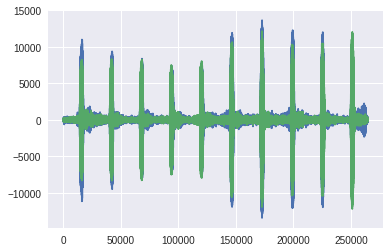

In [6]:
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav

rate, data = wav.read(audio_file)

plt.plot(data)
plt.show()

In [0]:
def stereoToMono(audiodata):
  mono_audio = []
  
  for i in range(len(audiodata)):
        data = (audiodata[i][0]/2 + audiodata[i][1]/2)
        mono_audio.append(data)

  return np.array(mono_audio, dtype='int16')

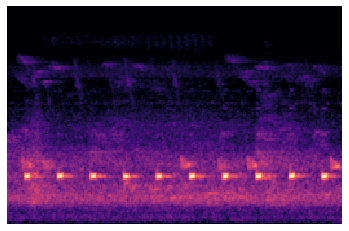

In [8]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import librosa
import librosa.display
import numpy as np

def plotSpectrogram(audio_file):
  samples, sample_rate = librosa.load(audio_file)
  fig = plt.figure()
  S = librosa.feature.melspectrogram(y=samples, sr=sample_rate)
  librosa.display.specshow(librosa.power_to_db(S, ref=np.max))

plotSpectrogram(audio_file)

In [9]:
!rm -r data/spectrograms
!mkdir data/spectrograms 
!mkdir data/spectrograms/common_tailorbird
!mkdir data/spectrograms/coppersmith_barbet
!mkdir data/spectrograms/red_wattled_lapwing

rm: cannot remove 'data/spectrograms': No such file or directory


In [0]:
def saveSpectrograms(readFolder, writeFolder):
  for i, audio in enumerate(os.listdir(readFolder)):
    audio_file = readFolder + '/' + audio
    samples, sample_rate = librosa.load(audio_file)
    fig = plt.figure()
    S = librosa.feature.melspectrogram(y=samples, sr=sample_rate)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max))    
    fig.savefig(writeFolder+'/'+'img_{0:03d}.jpg'.format(i), bbox_inches='tight', pad_inches = 0)
    plt.close(fig) 
    
saveSpectrograms('data/common_tailorbird', 'data/spectrograms/common_tailorbird')
saveSpectrograms('data/coppersmith_barbet', 'data/spectrograms/coppersmith_barbet')
saveSpectrograms('data/red_wattled_lapwing', 'data/spectrograms/red_wattled_lapwing')

In [0]:
import os, random

def scan_folder(parent, count):
    current_path = parent
    num_folders = len(os.listdir(parent))
    # iterate over all the files in directory 'parent'
    count = count if num_folders >= count else num_folders
    for file_name in random.sample(os.listdir(parent), count):   
        if file_name.endswith(".jpg"):                       
            print(parent+'/'+file_name) 
            img = plt.imread(parent+'/'+file_name)        
            plt.axis('off')
            plt.imshow(img)
            plt.show()
        else:
            current_path = "".join((parent, "/", file_name))
            if os.path.isdir(current_path):
                # if we're checking a sub-directory, recall this method
                print('Folder changed to: {}'.format(current_path))  
                scan_folder(current_path)
    else:
      print('error')

data/spectrograms/coppersmith_barbet/img_055.jpg


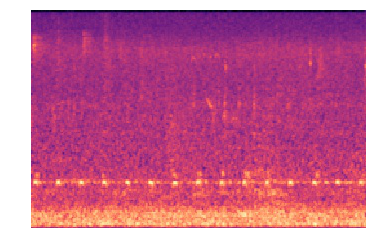

data/spectrograms/coppersmith_barbet/img_034.jpg


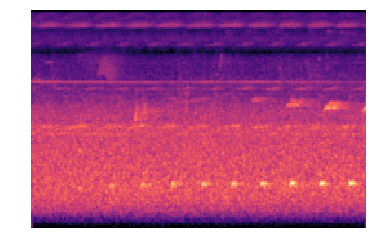

data/spectrograms/coppersmith_barbet/img_070.jpg


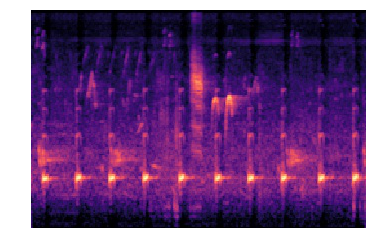

data/spectrograms/coppersmith_barbet/img_100.jpg


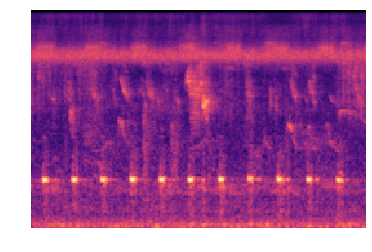

data/spectrograms/coppersmith_barbet/img_067.jpg


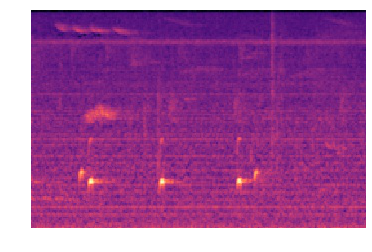

error


In [12]:
scan_folder('data/spectrograms/coppersmith_barbet', 5)

# Training

In [0]:
from fastai import *
from fastai.vision import *

In [14]:
path = Path('data/spectrograms')
path.ls()

[PosixPath('data/spectrograms/coppersmith_barbet'),
 PosixPath('data/spectrograms/red_wattled_lapwing'),
 PosixPath('data/spectrograms/common_tailorbird')]

In [0]:
classes = ['common_tailorbird', 'coppersmith_barbet', 'red_wattled_lapwing']

In [16]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_workers=8)

common_tailorbird


coppersmith_barbet


red_wattled_lapwing


In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2, size=224, num_workers=4).normalize(imagenet_stats)

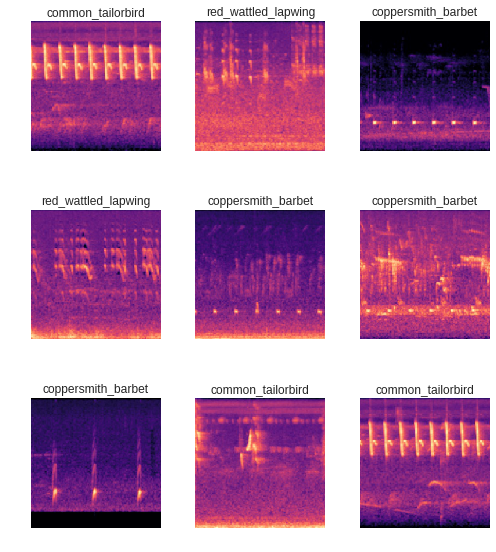

In [18]:
data.show_batch(rows=3, figsize=(7,8))

## Training: resnet50

Start training our model. We will use a convolutional neural network backbone and a fully connected head with a single hidden layer as a classifier. 

We will train for 5 epochs (5 cycles through all our data).

In [19]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:105: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
102502400it [00:01, 83832444.85it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


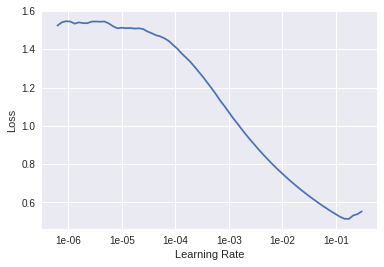

In [20]:
learn.lr_find()
learn.recorder.plot()

In [21]:
learn.fit_one_cycle(5, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.395037,1.145543,0.606557,00:11
1,1.390884,1.109702,0.573770,00:05
2,1.293287,1.042170,0.606557,00:05
3,1.193472,0.963645,0.491803,00:05
4,1.116839,0.891006,0.360656,00:05


In [0]:
learn.save('model')

## Interpretation

In [23]:
learn.load('model')

Learner(data=ImageDataBunch;

Train: LabelList (245 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
coppersmith_barbet,coppersmith_barbet,coppersmith_barbet,coppersmith_barbet,coppersmith_barbet
Path: data/spectrograms;

Valid: LabelList (61 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
red_wattled_lapwing,red_wattled_lapwing,red_wattled_lapwing,red_wattled_lapwing,coppersmith_barbet
Path: data/spectrograms;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, ke

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

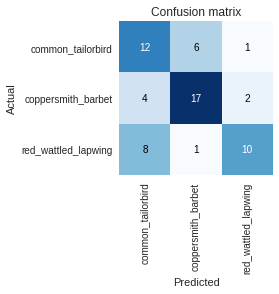

In [25]:
interp.plot_confusion_matrix()

# User Interface

In [27]:
#Give audio path below
test_file = 'data/test/rwl_user_test.wav'
IPython.display.Audio(test_file)

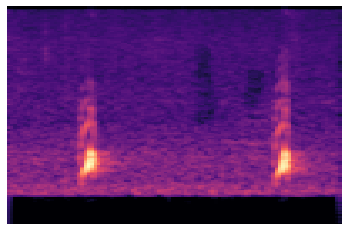

In [28]:
def plotSpectrogram(test_file):
  samples, sample_rate = librosa.load(test_file)
  fig = plt.figure()
  S = librosa.feature.melspectrogram(y=samples, sr=sample_rate)
  librosa.display.specshow(librosa.power_to_db(S, ref=np.max))

plotSpectrogram(test_file)    
saveSpectrograms('data/test', 'data/spectrograms')


In [0]:
defaults.device = torch.device('cpu')

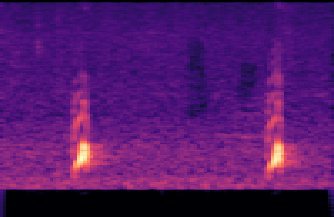

In [30]:
img = open_image(path/'img_000.jpg')
img

In [31]:
classes = ['common_tailorbird', 'coppersmith_barbet','red_wattled_lapwing']
data2 = ImageDataBunch.single_from_classes(path, classes, size=224).normalize(imagenet_stats)
learn = create_cnn(data2, models.resnet50)
learn.load('model')

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:105: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


Learner(data=ImageDataBunch;

Train: LabelList (0 items)
x: ImageList

y: CategoryList

Path: data/spectrograms;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: data/spectrograms;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1,

In [32]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category coppersmith_barbet

In [0]:
!rm 'data/spectrograms/img_000.jpg' 

In [0]:
#if pred_class==red_wattled_lapwing:
from PIL import Image
import requests
from io import BytesIO


response = requests.get('https://upload.wikimedia.org/wikipedia/commons/0/08/Red-wattled_Lapwing_%28Vanellus_indicus%29_M_IMG_1078.jpg')
img1 = Image.open(BytesIO(response.content))
img1

In [0]:
#if pred_class==coppersmith_barbet:
from PIL import Image
import requests
from io import BytesIO


response = requests.get('http://atozbirds.butterdaisy.com/wp-content/uploads/2014/12/coppersmith_barbet-backview.jpg')
img2 = Image.open(BytesIO(response.content))
img2

In [0]:
#if pred_class==common_tailorbird:
from PIL import Image
import requests
from io import BytesIO


response = requests.get('https://upload.wikimedia.org/wikipedia/commons/7/7e/%E2%99%80_Common_tailorbird_%28Orthotomus_sutorius%29_Photograph_by_Shantanu_Kuveskar.jpg')
img3 = Image.open(BytesIO(response.content))
img3